In [105]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import hilbert
from antropy import sample_entropy
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import glob
from collections import Counter
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [106]:
device = torch.device("cuda")

In [107]:
dataf = "103Features.csv"
df = pd.read_csv(dataf)
epohe_labels = df["Sleep_Stage"].tolist()

list_feature = df.drop(columns=["Sleep_Stage"]).values.tolist()
list_feature = [row[1:] for row in list_feature]

In [108]:
def balance_classes(X, y):
    valid_mask = y != 'Missing'
    X = X[valid_mask]
    y = y[valid_mask]
    unique_classes = np.unique(y)
    min_class_count = min(Counter(y).values()) 
    print(min_class_count)
    X_balanced = []
    y_balanced = []

    for cls in unique_classes:

        X_cls = X[y == cls]
        y_cls = y[y == cls]

        X_down, y_down = resample(X_cls, y_cls, 
                                  replace=False,
                                  n_samples=min_class_count,
                                  random_state=42)

        X_balanced.append(X_down)
        y_balanced.append(y_down)

    X_final = np.vstack(X_balanced)
    y_final = np.concatenate(y_balanced)

    return X_final, y_final 

In [109]:
arr = np.array(list_feature)
arr = np.nan_to_num(arr)  
scaler = StandardScaler()
X_np = scaler.fit_transform(arr)
y_raw = pd.Series(epohe_labels).astype("category")
y_np = y_raw.cat.codes.values

In [110]:
#X_np, y_np = balance_classes(X_np, y_np)

In [111]:
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)

In [112]:
dataset = TensorDataset(X, y)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
val_ds

In [113]:
# class SimpleNet(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super().__init__()
#         self.fc1 = nn.Linear(input_size, 64)
#         self.fc2 = nn.Linear(64, 128)
#         self.fc3 = nn.Linear(128, 256)
#         self.fc4 = nn.Linear(256, 128)
#         self.fc5 = nn.Linear(128, 64)
#         self.fc6 = nn.Linear(64, 32)
#         self.dropout = nn.Dropout(0.3)
#         self.out = nn.Linear(32, num_classes)

#     def forward(self, x):
#         x = F.elu(self.fc1(x))
#         x = F.elu(self.fc2(x))
#         x = F.elu(self.fc3(x))
#         x = F.elu(self.fc4(x))
#         x = F.elu(self.fc5(x))
#         x = F.elu(self.fc6(x))
#         x = self.dropout(x)
#         return self.out(x)

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.25)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)

        x = F.gelu(self.fc2(x))
        x = self.dropout(x)

        x = F.gelu(self.fc3(x))
        x = self.dropout(x)

        x = F.gelu(self.fc4(x))
        x = self.dropout(x)

        x = F.gelu(self.fc5(x))
        x = self.dropout(x)

        return self.out(x)

In [115]:
input_size = X.shape[1]
num_classes = len(np.unique(y_np))
model = SimpleNet(input_size, num_classes)
model.to(device)


SimpleNet(
  (fc1): Linear(in_features=103, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (out): Linear(in_features=64, out_features=5, bias=True)
)

In [116]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay= 0.003)

scheduler = ReduceLROnPlateau(optimizer, mode="max", patience=10, factor=0.5, min_lr=1e-6)


In [118]:
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(40):
    model.train()
    tr_tacni = 0
    tr_ukupno = 0
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)
        #print(predicted, batch_y)
        tr_tacni += (predicted == batch_y).sum().item()
        tr_ukupno += batch_y.size(0)

    train_acc = tr_tacni / tr_ukupno
    avg_loss = epoch_loss / len(train_loader)

    model.eval()
    val_tacni = 0
    val_ukupno = 0

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_outputs = model(val_X)
            _, val_pred = torch.max(val_outputs, dim=1)
            val_tacni += (val_pred == val_y).sum().item()
            val_ukupno += val_y.size(0)

    val_acc = val_tacni / val_ukupno

    scheduler.step(avg_loss)

    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%, Learning Rate: {current_lr:.6f}")

Epoch 1, Loss: 0.3186, Train Acc: 87.59%, Val Acc: 86.63%, Learning Rate: 0.000500
Epoch 2, Loss: 0.3120, Train Acc: 87.89%, Val Acc: 86.61%, Learning Rate: 0.000500
Epoch 3, Loss: 0.3057, Train Acc: 88.23%, Val Acc: 86.84%, Learning Rate: 0.000500
Epoch 4, Loss: 0.3037, Train Acc: 88.43%, Val Acc: 86.32%, Learning Rate: 0.000500
Epoch 5, Loss: 0.3003, Train Acc: 88.27%, Val Acc: 86.74%, Learning Rate: 0.000500
Epoch 6, Loss: 0.2961, Train Acc: 88.47%, Val Acc: 86.51%, Learning Rate: 0.000500
Epoch 7, Loss: 0.2923, Train Acc: 88.69%, Val Acc: 86.83%, Learning Rate: 0.000500
Epoch 8, Loss: 0.2895, Train Acc: 88.66%, Val Acc: 86.87%, Learning Rate: 0.000250
Epoch 9, Loss: 0.2697, Train Acc: 89.25%, Val Acc: 87.03%, Learning Rate: 0.000250
Epoch 10, Loss: 0.2598, Train Acc: 89.76%, Val Acc: 86.99%, Learning Rate: 0.000250
Epoch 11, Loss: 0.2582, Train Acc: 89.75%, Val Acc: 87.04%, Learning Rate: 0.000250
Epoch 12, Loss: 0.2578, Train Acc: 90.00%, Val Acc: 87.00%, Learning Rate: 0.000250
E

In [119]:
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc
}

torch.save(checkpoint, 'checkpoints/model_checkpoint.pth') 

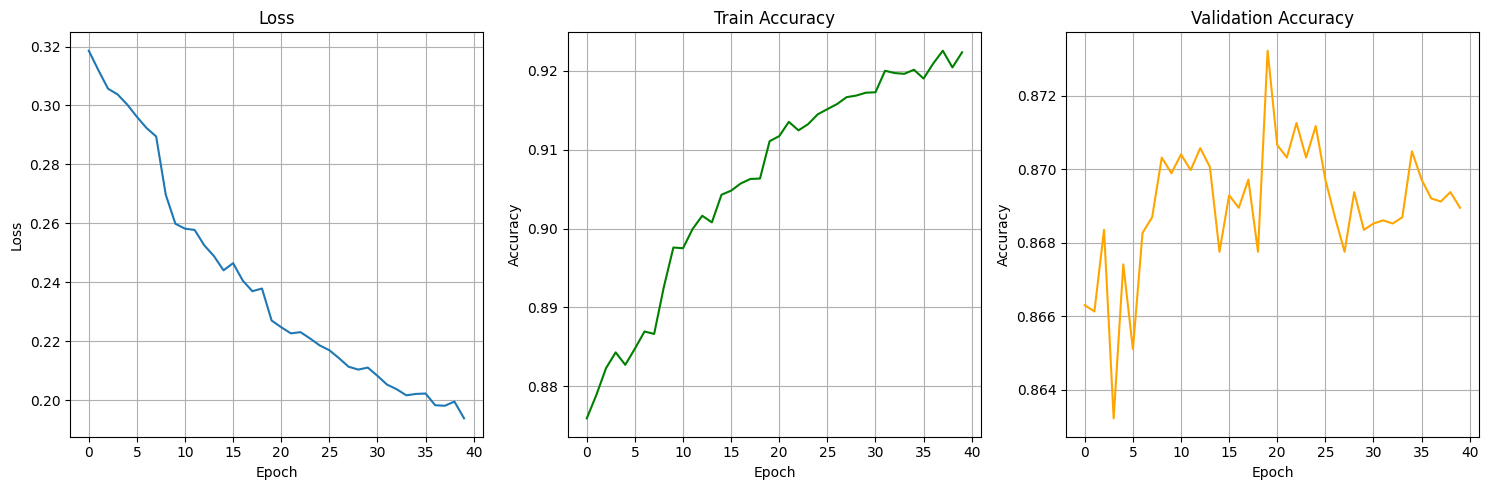

In [120]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

plt.tight_layout()
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)